# Convex_Function

In [1]:
import numpy as np

a_array = np.arange(-1.5, 3, 0.01)
a_array = a_array.reshape(a_array.shape[0],1)

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [2]:
import math
def get_objective(a):
    result = (-math.sin(3*a) - a**2 + 0.7*a)#-(a**2)
    return result

In [3]:
def get_objective(a, other=False):
    result = (-math.sin(3*a) - a**2 + 0.7*a) + 0*int(a)
    if other:
        result = -result
    return result

In [4]:
import math

accuracy_all=[]
a_ideal =0

for a in a_array:
    results = get_objective(a)
    accuracy_all.append(results)
    
accuracy_all= np.array(accuracy_all)

print(accuracy_all.shape)

print("Idea Values of a:",a_array[np.argmax(accuracy_all)],np.max(accuracy_all))

(450, 1)
Idea Values of a: [-0.36] 0.5003578068849475


# Plot of the exact  objective

In [5]:
import matplotlib.pyplot as plt

def plot_exact_function():
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)

    ax.plot(a_array, accuracy_all)

    ax.set_xlabel('a')
    ax.set_ylabel('objective')
    plt.show()

plot_exact_function()

<Figure size 1000x500 with 1 Axes>

# Initial Values for BL

In [6]:
a1 = 0.5
accuracy1 = get_objective(a1)
print('accuracy1 = ',accuracy1)

a2 = 0.5
accuracy2 = get_objective(a2, other=True)

print('accuracy2 = ',accuracy2)


X_init = np.array([[a1], [a2]])
Y_init= np.array([accuracy1, accuracy2])

Y_init = Y_init.reshape(Y_init.shape[0],1)

accuracy1 =  -0.8974949866040546
accuracy2 =  0.8974949866040546


In [7]:
print(X_init.shape,Y_init.shape)

(2, 1) (2, 1)


In [8]:
# Domain Size = |D|
Domain_Size = a_array.shape[0]
print(Domain_Size)

450


# Plot the Gaussian Process predictions

In [9]:
def Plot_the_function_and_Exact_values(gpr,X_samples,Y_samples, aq_fn_values):
    
    fig = plt.figure(figsize=(15,8))
    
    ax = fig.add_subplot(1, 2, 1)
    accuracy_pred, sigma = gpr.predict(a_array, return_std=True)
    sigma = sigma.reshape(sigma.shape[0],1)
    accuracy_pred = accuracy_pred.reshape(accuracy_pred.shape[0],1)
    
    accuracy_pred1 = accuracy_pred +  5*sigma
    
    accuracy_pred2 = accuracy_pred - 5*sigma
    
    return_acc1 = np.max(accuracy_pred)    
    ax.plot(a_array, accuracy_pred,label='Surrogate function',lw=2)
    
    ax.fill_between(a_array.ravel(), 
                     accuracy_pred.ravel() + 1.96 * sigma.ravel(), 
                     accuracy_pred.ravel() - 1.96 * sigma.ravel(), 
                     alpha=0.1,label="uncertainity") 
    
    #plotting the samples
    ax.plot(X_samples, Y_samples, 'kx', mew=3, label='Samples')
    
    
    ax.plot(a_array, accuracy_all, 'y--', lw=2, label='Noise-free objective')
    
    ax.plot(a_array, aq_fn_values, 'r--', lw=2, label='Aq function')
    
    plt.legend()
    plt.show()
    
    return return_acc1
    


# UCB

In [10]:
def Upper_Confidence_Bound(X, gpr,t):
    ''' Compute the upper confidence bound '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu = mu.reshape(mu.shape[0],1)
    sigma = sigma.reshape(sigma.shape[0],1)
    
    alpha = 2*math.log(Domain_Size*(t)*(t)*math.pi*math.pi/(6*0.1))
    alpha = math.sqrt(alpha)
#     alpha = 3
    print("alpha: ", alpha)
    Value = mu + (alpha)*sigma    
    x_index = np.argmax(Value)
    return X[x_index], Value

In [11]:
X_matrix = a_array

In [12]:
# Functions from the Mango library 
from scipy.stats import uniform
from mango.domain.distribution import loguniform
from mango.domain.domain_space import domain_space


param_dict = {"a": uniform(-1.5, 4.5), "b": }

ds = domain_space(param_dict,450)

# Bayesian learning Sequential Iterations

Starting GPR Assumption
Iteration count: 1
alpha:  4.221263549751225
alpha:  4.221263549751225
2.972580675244627 -7.241017632936063


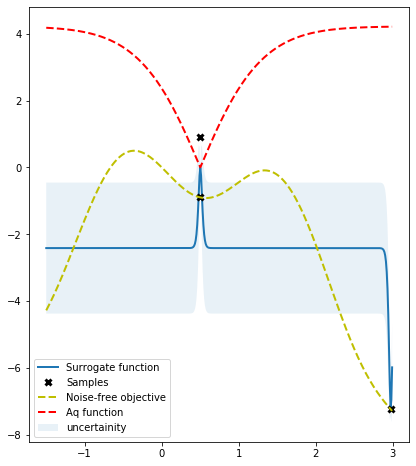

Iteration count: 2
alpha:  4.537802847050331
alpha:  4.537802847050331
0.4706149508858144 -0.879441756300226


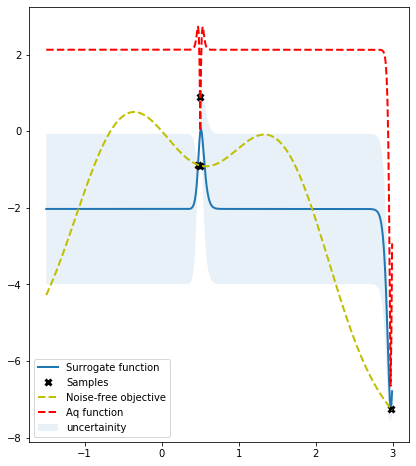

Iteration count: 3
alpha:  4.713121588833748
alpha:  4.713121588833748
0.5680315293507499 -0.9161666816491121


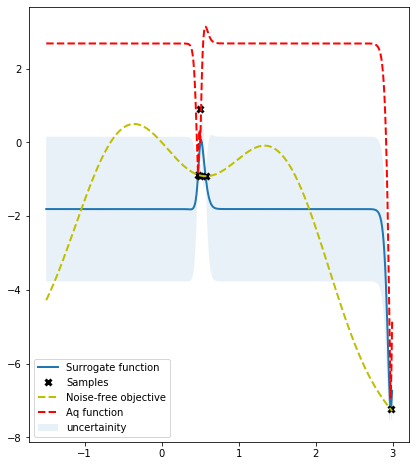

Iteration count: 4
alpha:  4.833657352454544
alpha:  4.833657352454544
0.682524058410622 -0.8765514054521832


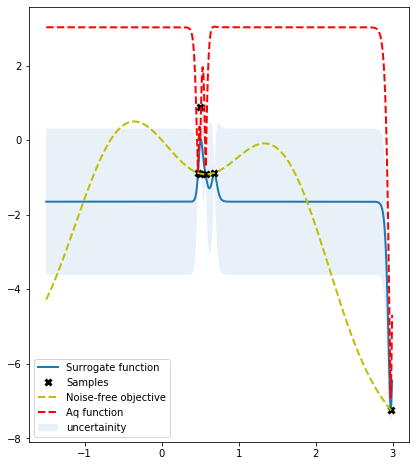

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
noise = 0.01

# Gaussian process with Matern kernel as surrogate model
gpr = GaussianProcessRegressor(kernel=Matern(nu=2.5, length_scale=[1]),n_restarts_optimizer=10,random_state =1 ,normalize_y=True)


# Number of iterations
n_iter = 4

X_sample = X_init
Y_sample = Y_init
gpr.fit(X_sample, Y_sample)

#Printing the starting assumption
print('Starting GPR Assumption')
# Plot_the_function_and_Exact_values(gpr,X_sample,Y_sample)

for i in range(n_iter):
    
    print('Iteration count:',i+1)
    
    domain_list = ds.get_domain()
    X_domain_np = ds.convert_GP_space(domain_list)
        
    curr_sample, _ = Upper_Confidence_Bound(X_domain_np,gpr,i+1)
    _, aq_fn_values = Upper_Confidence_Bound(a_array, gpr, i+1)
    results = get_objective(curr_sample[0])
    print(curr_sample[0],results)
    
    X_sample = np.vstack((X_sample, curr_sample))
    Y_sample = np.vstack((Y_sample, results))
    
    
    gpr.fit(X_sample, Y_sample)
    Plot_the_function_and_Exact_values(gpr,X_sample,Y_sample, aq_fn_values)
    

# Scatter Plot

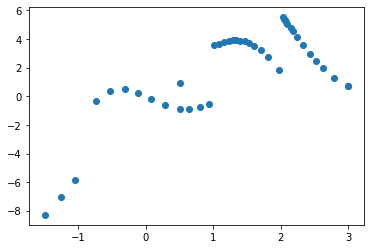

In [111]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.scatter(X_sample[:,0], Y_sample, marker='o')

plt.show()

In [22]:
gpr.kernel_.theta

array([-3.25])